# Task 2: Multi Object Prediction
## Prediction using constant velocity model & constant acceleration model

### import libraries

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import random

### Q1: Using constant velocity model to predict

In [57]:
def Q1_prediction(info,tracks):
    """
    constant velocity model prediction
    """
    all_agent_trajs = info['all_agent']
    current_states = all_agent_trajs[:, 10]  # [Na, 10]
    all_pred_trajs=[]

    for agent_idx in tracks:
        # get current state
        current = current_states[agent_idx]  # [10]
        vx, vy = current[7], current[8]  # current velocity

        # generate prediction trajectory
        pred_traj = []
        for t in range(1, 81):  # predict 80 steps
            dx = vx * t * 0.1  # 0.1 second/step
            dy = vy * t * 0.1
            pred_traj.append([current[0]+dx, current[1]+dy])
        pred_traj = np.array(pred_traj)  # [80, 2]

        all_pred_trajs.append(pred_traj)

    return all_pred_trajs

### Q2: Using constant acceleration model to predict

In [58]:
def Q2_prediction(info,tracks):
    """
    constant acceleration model prediction
    """
    all_agent_trajs = info['all_agent']
    current_states = all_agent_trajs[:, 10]  # [Na, 10]
    all_pred_trajs=[]

    for agent_idx in tracks:
        # print(agent_idx)
        # get history velocity to calculate acceleration
        current = current_states[agent_idx]  # [10]
        vx, vy = current[7], current[8]  # current velocity
        prev_vel = all_agent_trajs[agent_idx, 9, 7:9]  # t-1 moment velocity
        current_vel = current_states[agent_idx, 7:9]
        dt = 0.1  # 时间间隔
        ax = (current_vel[0] - prev_vel[0]) / dt
        ay = (current_vel[1] - prev_vel[1]) / dt
        
        # generate prediction trajectory
        pred_traj = []
        for t in range(1, 81):
            time = t * 0.1
            dx = current_vel[0]*time + 0.5*ax*(time**2)
            dy = current_vel[1]*time + 0.5*ay*(time**2)
            pred_traj.append([current[0]+dx, current[1]+dy])
        pred_traj = np.array(pred_traj)  # [80, 2]

        all_pred_trajs.append(pred_traj)

    return all_pred_trajs

### get ground truth trajectory

In [59]:
def ground_truth(info,tracks):
    all_agent_trajs = info['all_agent']
    agents_to_predict = all_agent_trajs[tracks]
    all_ground_truth=[]

    for agent_idx in range(agents_to_predict.shape[0]):
        trajectory = agents_to_predict[agent_idx, :, :2]  # get all x,y coordinates
          
        # filter invalid data (valid=1 represents valid)
        # valid_mask = agents_to_predict[agent_idx, :, -1] == 1.0
        # valid_traj = trajectory[valid_mask]

        all_ground_truth.append(trajectory)
    
    return all_ground_truth

### evaluation: ADE & FDE


In [60]:
def evaluation(gt_trajs,pred_trajs):
     ade_3s =[]
     ade_5s = []
     ade_8s = []
     fde_3s = []
     fde_5s = []
     fde_8s = []
     time_steps = [30, 50, 80]  # 3s,5s,8s

     for t in time_steps:
          # print(t)
          for i in range(len(gt_trajs)):
               pred = pred_trajs[i][:t]
               # print(pred)
               true = gt_trajs[i][:t]
               error = np.linalg.norm(pred - true, axis=1).mean()
          
               # calculate ADE
               if t == 30:       
                    ade_3s.append(error)
               elif t == 50:
                    ade_5s.append(error)
               elif t == 80:
                    ade_8s.append(error)
                    
               # calculate FDE
               if t == 30:
                    fde_3s.append(np.linalg.norm(pred[-1]-true[-1]))
               elif t == 50:
                    fde_5s.append(np.linalg.norm(pred[-1]-true[-1]))
               elif t == 80:
                    fde_8s.append(np.linalg.norm(pred[-1]-true[-1]))

     return ade_3s,ade_5s,ade_8s,fde_3s,fde_5s,fde_8s

### running code to get the ADE & FDE of each agent

In [100]:
# you can change the senario index, index=2 is to show the result of senario 3
senario_index = 4
data_path = 'task2_data'
file=os.listdir(data_path)[senario_index]

info = np.load(data_path+'/'+file,allow_pickle=True)
all_agent_trajs = info['all_agent']

tracks = info['predict_list']
gt_trajs=ground_truth(info,tracks)
pred_trajs_q1=Q1_prediction(info,tracks)
pred_trajs_q2=Q2_prediction(info,tracks)

# get all agent's last 80 trajectory points
evaluation_gt_trajs = [agent_traj[-80:] for agent_traj in gt_trajs]  

q1_ade_3s,q1_ade_5s,q1_ade_8s,q1_fde_3s,q1_fde_5s,q1_fde_8s=evaluation(evaluation_gt_trajs,pred_trajs_q1)
q2_ade_3s,q2_ade_5s,q2_ade_8s,q2_fde_3s,q2_fde_5s,q2_fde_8s=evaluation(evaluation_gt_trajs,pred_trajs_q2)

for i in range(len(tracks)):
    print(f'agent {tracks[i]}:')
    print(f'Q1 ADE 3s: {q1_ade_3s[i]:.2f}, Q1 ADE 5s: {q1_ade_5s[i]:.2f}, Q1 ADE 8s: {q1_ade_8s[i]:.2f}')
    print(f'Q1 FDE 3s: {q1_fde_3s[i]:.2f}, Q1 FDE 5s: {q1_fde_5s[i]:.2f}, Q1 FDE 8s: {q1_fde_8s[i]:.2f}')
    print('-'*50)
    print(f'Q2 ADE 3s: {q2_ade_3s[i]:.2f}, Q2 ADE 5s: {q2_ade_5s[i]:.2f}, Q2 ADE 8s: {q2_ade_8s[i]:.2f}')
    print(f'Q2 FDE 3s: {q2_fde_3s[i]:.2f}, Q2 FDE 5s: {q2_fde_5s[i]:.2f}, Q2 FDE 8s: {q2_fde_8s[i]:.2f}')
    print('='*50)
    print()

agent 27:
Q1 ADE 3s: 1.44, Q1 ADE 5s: 2.25, Q1 ADE 8s: 6.94
Q1 FDE 3s: 2.94, Q1 FDE 5s: 5.68, Q1 FDE 8s: 24.32
--------------------------------------------------
Q2 ADE 3s: 2.79, Q2 ADE 5s: 10.67, Q2 ADE 8s: 33.80
Q2 FDE 3s: 9.41, Q2 FDE 5s: 37.65, Q2 FDE 8s: 109.00

agent 65:
Q1 ADE 3s: 1.92, Q1 ADE 5s: 5.26, Q1 ADE 8s: 13.37
Q1 FDE 3s: 5.50, Q1 FDE 5s: 15.36, Q1 FDE 8s: 39.36
--------------------------------------------------
Q2 ADE 3s: 0.15, Q2 ADE 5s: 0.43, Q2 ADE 8s: 1.19
Q2 FDE 3s: 0.45, Q2 FDE 5s: 1.32, Q2 FDE 8s: 3.74



### visualization

In [66]:
def visulization(info,ground_truth,pred_trajs_q1,pred_trajs_q2):
     ax = plt.gca()
     fig = plt.gcf()
     fig.set_facecolor('xkcd:grey') 
     ax.set_facecolor('xkcd:grey')

     road_polylines= info['road_polylines']
     for polyline in road_polylines:
          map_type = polyline[0,6]
          if map_type == 6:
               plt.plot(polyline[:, 0], polyline[:, 1], 'w', linestyle='dashed', linewidth=1)
          elif map_type == 7:
               plt.plot(polyline[:, 0], polyline[:, 1], 'w', linestyle='solid', linewidth=1)
          elif map_type == 8:
               plt.plot(polyline[:, 0], polyline[:, 1], 'w', linestyle='solid', linewidth=1)
          elif map_type == 9:
               plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='dashed', linewidth=1)
          elif map_type == 10:
               plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='dashed', linewidth=1)
          elif map_type == 11:
               plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='solid', linewidth=1)
          elif map_type == 12:
               plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='solid', linewidth=1)
          elif map_type == 13:
               plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='dotted', linewidth=1)
          elif map_type == 15:
               plt.plot(polyline[:, 0], polyline[:, 1], 'k', linewidth=1)
          elif map_type == 16:
               plt.plot(polyline[:, 0], polyline[:, 1], 'k', linewidth=1)

     
     for agent_idx in range(len(pred_trajs_q1)):
          # ground truth -- red
          plt.plot(ground_truth[agent_idx][10:-1:15,0], ground_truth[agent_idx][10:-1:15,1],
                         color='red',      
                         linestyle='-',          # 实线连接
                         linewidth=0.8,          # 线宽
                         marker='*',             # 星形标记
                         markersize=2,           # 标记大小
                         markevery=1,            # 每个点都显示标记
                         zorder=4)
          # constant velocity model -- limegreen
          plt.plot(pred_trajs_q1[agent_idx][0:-1:15,0], pred_trajs_q1[agent_idx][0:-1:15,1],
                         color='limegreen',      # 更醒目的绿色
                         linestyle='-',          # 实线连接
                         linewidth=0.5,          # 线宽
                         marker='*',             # 星形标记
                         markersize=3,           # 标记大小
                         markevery=1,            # 每个点都显示标记
                         zorder=4)
          # constant acceleration model -- blue
          plt.plot(pred_trajs_q2[agent_idx][0:-1:15,0], pred_trajs_q2[agent_idx][0:-1:15,1],
                         color='blue',      
                         linestyle='-',          # 实线连接
                         linewidth=0.5,          # 线宽
                         marker='*',             # 星形标记
                         markersize=3,           # 标记大小
                         markevery=1,            # 每个点都显示标记
                         zorder=4)

     ax.axis([-150+ ground_truth[0][0,0], 150+ ground_truth[0][0,0], -150+ ground_truth[0][0,1], 150 + ground_truth[0][0,1]])
     scenario_id= info['scenario_id']
     filename=f'./visualization/{scenario_id}.png'
     
     plt.savefig(filename, bbox_inches='tight', dpi=150)  # 调整保存参数
     # plt.close()
     plt.show()

### running code to visualize the result

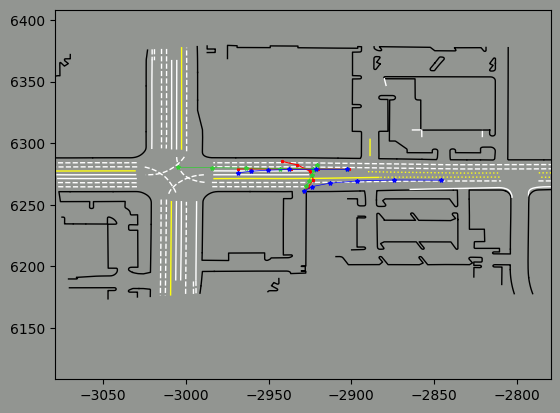

In [101]:
# show the results of all tracking agents 
visulization(info,gt_trajs,pred_trajs_q1,pred_trajs_q2)